## 4. Das neuronale Netzwerk trainieren und testen

Jetzt kommen wir endlich zum Herzstück des Projekts: Das neuronale Netzwerk. Genauer: Ein Multi-Layer-Perzeptron-Klassifikator. Allgemeinere Dokumentation für diese Art von Maschinellem Lernen mit Scikit-learn findet sich [hier](https://scikit-learn.org/stable/modules/neural_networks_supervised.html).

Hier kommt wieder eine neue Library ins Spiel:
[`Scikit-learn`](https://de.wikipedia.org/wiki/Scikit-learn) (ehemals scikits.learn) ist eine Bibliothek zum maschinellen Lernen.


In [15]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import precision_recall_fscore_support as score
import numpy as np


mode = 1
# 1 = Nationalratswahlen
# 2 = Ständeratswahlen

filename_csv_all = "nationalrat_all.csv" if mode == 1 else "ständerat_all.csv"
filename_csv_train = "nationalrat_train.csv" if mode == 1 else "ständerat_train.csv"
filename_csv_test = "nationalrat_test.csv" if mode == 1 else "ständerat_test.csv"

Als erstes müssen die Trainingsdaten in Inputs und Labels aufgeteilt werden. Die Inputs sind in diesem Fall die Antworten zwischen 0 und 1 und die Labels sind die Parteien. Das Netzwerk soll dann lernen, in den Inputs - also den Antworten - Muster zu finden die auf die Labels - also die Parteien - schliessen lassen.

Vielleicht haben Sie schon bemerkt, dass die Parteinamen aktuell noch Text sind. Eigentlich müssten sie deshalb noch in Zahlen umgewandelt werden. [`Scikit-learn`](https://de.wikipedia.org/wiki/Scikit-learn) macht das jedoch automatisch.

---

> **Für die Interessierten**
>
> Eine Möglichkeit wäre, jeder Partei eine Zahl zuzuweisen, also zB. `Piratenpartei=0, SP=0.1, Grüne=0.2, ...`, jedoch macht das aus mathematischer Sicht keinen Sinn, da die Parteien keine intrinsische Reihenfolge haben. Besser ist es, jeder kandidierenden Person einen Eintrag für jede Partei zu erstellen. Dieser Eintrag ist `0`, wenn die Person nicht in der Partei ist und `1`, wenn sie es ist. Da jede Person in genau einer Partei ist (zumindest nach Datensatz von Smartvote), hat jede Person genau eine Eins unter vielen Nullen, deshalb wird diese Art von Liste - auf mathematisch Vektor - One-Hot-Vector oder zu Deutsch
> [1-aus-n-Code](https://de.wikipedia.org/wiki/1-aus-n-Code) genannt, wobei n in diesem Fall für die Anzahl Parteien steht.


In [16]:
def csv_to_vectors(filename):
    training_df = pd.read_csv(filename)

    input_columns = [str(q) for q in range(32214, 32289)]
    input_columns.append("gender")

    inputs = training_df[input_columns]
    labels = training_df[["partyAbbreviation"]]

    return inputs, labels


training_inputs, training_labels = csv_to_vectors(filename_csv_train)

training_inputs

,32214,32215,32216,32217,32218,32219,32220,32221,32222,32223,...,32280,32281,32282,32283,32284,32285,32286,32287,32288,gender
0,0.00,0.75,1.00,0.00,1.00,1.00,0.00,0.75,0.00,0.00,...,1.00,1.00,1.00,0.00,1.00,0.00,0.50,0.00,1.00,0.0
1,0.75,0.25,0.75,0.00,0.25,0.25,0.75,0.00,0.25,0.25,...,0.67,0.50,0.75,0.50,0.50,0.50,0.50,0.50,0.50,0.0
2,0.00,0.75,1.00,0.75,0.25,0.75,0.00,0.75,0.25,1.00,...,0.67,0.50,0.50,0.50,0.50,0.25,0.50,0.75,0.25,0.0
3,0.00,0.75,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.25,0.50,0.50,0.50,0.75,0.75,0.25,1.0
4,1.00,0.25,0.75,1.00,0.75,0.25,0.25,0.00,0.25,0.00,...,0.50,0.50,0.75,0.50,0.75,0.25,0.50,0.50,0.50,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3653,0.00,1.00,0.25,0.00,1.00,1.00,0.25,0.75,0.00,0.00,...,1.00,0.75,1.00,0.50,1.00,0.00,0.50,0.50,0.75,1.0
3654,0.00,1.00,0.25,0.00,1.00,1.00,0.00,0.25,0.00,0.00,...,1.00,1.00,1.00,0.50,1.00,0.00,0.50,0.00,1.00,0.0
3655,0.25,1.00,1.00,0.00,1.00,1.00,0.00,0.25,0.00,0.00,...,1.00,0.75,1.00,0.50,1.00,0.00,0.50,0.00,1.00,1.0
3656,1.00,0.75,1.00,0.25,1.00,0.00,0.00,1.00,0.75,0.25,...,0.83,0.50,1.00,0.25,0.75,0.75,0.75,0.25,0.50,0.0


Jetzt kann endlich das Netzwerk trainiert werden. Wir verwenden ein [Multi-Layer-Perzeptron](https://de.wikipedia.org/wiki/Multi-Layer-Perzeptron) als Modell. Mit den Parametern und besonders den `hidden_layer_sizes` musste experimentiert werden, bis die Genauigkeit zufriedenstellend war.

In [17]:
model = MLPClassifier(
    solver="adam",
    hidden_layer_sizes=(20, 30),
    activation="relu",
    verbose=True,
    max_iter=1000,
    tol=0.000001,
)

# Alle Parteien, die klassifizierbar sein sollen
parties = np.array(list(set(pd.read_csv(filename_csv_all)["partyAbbreviation"])))
model.classes_ = parties

# fit = trainieren
model.fit(training_inputs, training_labels.to_numpy().ravel())

Iteration 1, loss = 3.21380130
Iteration 2, loss = 2.91456695
Iteration 3, loss = 2.63989602
Iteration 4, loss = 2.38936052
Iteration 5, loss = 2.15441346
Iteration 6, loss = 1.96587139
Iteration 7, loss = 1.81853697
Iteration 8, loss = 1.70826190
Iteration 9, loss = 1.62780815
Iteration 10, loss = 1.56542330
Iteration 11, loss = 1.51929780
Iteration 12, loss = 1.48012601
Iteration 13, loss = 1.44163846
Iteration 14, loss = 1.41543683
Iteration 15, loss = 1.38224398
Iteration 16, loss = 1.35613238
Iteration 17, loss = 1.33144717
Iteration 18, loss = 1.30390056
Iteration 19, loss = 1.28172356
Iteration 20, loss = 1.26219499
Iteration 21, loss = 1.24046794
Iteration 22, loss = 1.22195693
Iteration 23, loss = 1.20841177
Iteration 24, loss = 1.19362590
Iteration 25, loss = 1.17948176
Iteration 26, loss = 1.17001101
Iteration 27, loss = 1.16040914
Iteration 28, loss = 1.14682464
Iteration 29, loss = 1.14336720
Iteration 30, loss = 1.13750624
Iteration 31, loss = 1.12608469
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(20, 30), max_iter=1000, tol=1e-06,
              verbose=True)

Testen wir doch gleich noch die Genauigkeit. Es ist beim Testen wichtig, dass keine Daten verwendet werden, die das Modell beim Trainieren schon gesehen hat.


In [18]:
test_inputs, test_labels = csv_to_vectors(filename_csv_test)

model.score(test_inputs, test_labels)

0.6319672131147541

~0.6 = 60%

Das heisst, dass etwa 60% der Kandidierenden zur richtigen Partei zugeordnet wurden!

Welche Parteien wurden denn Verwechselt?


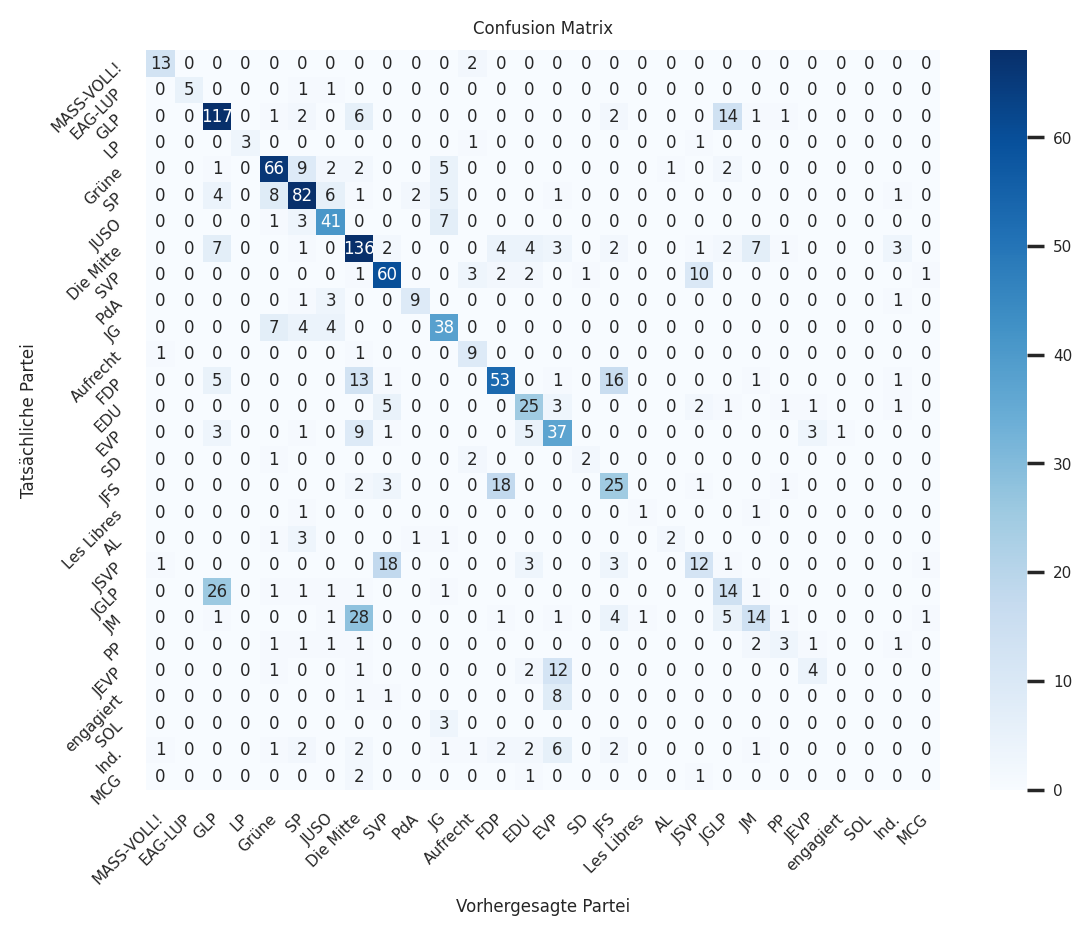

In [19]:
test_predictions = model.predict(test_inputs)

# Parteien nach F1-Score sortieren
parties = [party[0] for party in sorted(zip(parties, f1_score(test_labels, test_predictions, average=None, labels=parties)), key=lambda party: party[1], reverse=True)]


cm = confusion_matrix(test_labels, test_predictions, labels=parties)

plt.figure(dpi=200)
sns.set_theme(font_scale=0.5)
ax = plt.subplot()

sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g", vmax=np.max(cm) / 2)


ax.set_xlabel("Vorhergesagte Partei")
ax.set_ylabel("Tatsächliche Partei")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(parties, rotation_mode="anchor", ha="right", va="center")
ax.yaxis.set_ticklabels(parties, rotation_mode="anchor", ha="right", va="center")

plt.show()

Die Diagonale steht für die richtig vorhergesagten Parteien, alle anderen Verfärbungen sind Verwechslungen. Man kann erkennen, dass viele Verwechslungen zwischen Parteien mit ähnlichen Agenden stattfinden. So werden Jungparteien oftmals mit ihren Mutterparteien verwechselt. Man kann auch andere spannende Dinge beobachten. So gibt es Parteien, die kaum mit anderen verwechselt werden - z.B. die SP und die Partei der Arbeit - und es gibt solche die sehr oft mit anderen verwechselt werden - z.B. die EVP und die Piratenpartei. Vielleicht könnten wir versuchen, das zu formalisieren.

Bemerkung: *Ich habe keine Ahnung, weshalb die Jungparteien scheinbar auf einer Diagonalen liegen.*

In [20]:
precision, recall, fscore, support = score(
    test_labels, test_predictions, labels=parties, zero_division=0
)

df = pd.DataFrame([parties, precision, recall, fscore, support]).T

df.rename(
    columns={0: "Partei", 1: "Präzision", 2: "Recall", 3: "F1-Score", 4: "Vorkommen"},
    inplace=True,
)

df = df.sort_values("F1-Score", ascending=False)

df

,Partei,Präzision,Recall,F1-Score,Vorkommen
0,MASS-VOLL!,0.8125,0.866667,0.83871,15
1,EAG-LUP,1.0,0.714286,0.833333,7
2,GLP,0.713415,0.8125,0.75974,144
3,LP,1.0,0.6,0.75,5
4,Grüne,0.741573,0.75,0.745763,88
5,SP,0.732143,0.745455,0.738739,110
6,JUSO,0.683333,0.788462,0.732143,52
7,Die Mitte,0.657005,0.786127,0.715789,173
8,SVP,0.659341,0.75,0.701754,80
9,PdA,0.75,0.642857,0.692308,14


Der sogenannte [F1-Score](https://databasecamp.de/statistik/f1-score) ist das harmonische Mittel von Präzision und Recall. Er stellt in diesem Fall in etwa dar, wie häufig eine Partei **nicht** verwechselt wurde. Man kann also erkennen, dass die Parteien tatsächlich sehr unterschiedlich oft richtig erkannt werden. Es scheint, also ob Parteien mit eher radikalen Agenden am häufigsten richtig erkannt werden und Jungparteien am seltensten. Die Mitte könnte so hoch auf der Rangliste sein, weil sie die meisten Kandidierenden hat, das Netzwerk also viele Beispiele gesehen hat.